In [0]:
#Setting up Kaggle

!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 /root/.kaggle/kaggle.json

In [2]:
#Downloading and Unzipping Data

!kaggle competitions download -c dogs-vs-cats-redux-kernels-edition
!unzip dogs-vs-cats-redux-kernels-edition.zip
!unzip train.zip
# rm -r 'train'

Streaming output truncated to the last 5000 lines.
  inflating: train/dog.55.jpg        
  inflating: train/dog.550.jpg       
  inflating: train/dog.5500.jpg      
  inflating: train/dog.5501.jpg      
  inflating: train/dog.5502.jpg      
  inflating: train/dog.5503.jpg      
  inflating: train/dog.5504.jpg      
  inflating: train/dog.5505.jpg      
  inflating: train/dog.5506.jpg      
  inflating: train/dog.5507.jpg      
  inflating: train/dog.5508.jpg      
  inflating: train/dog.5509.jpg      
  inflating: train/dog.551.jpg       
  inflating: train/dog.5510.jpg      
  inflating: train/dog.5511.jpg      
  inflating: train/dog.5512.jpg      
  inflating: train/dog.5513.jpg      
  inflating: train/dog.5514.jpg      
  inflating: train/dog.5515.jpg      
  inflating: train/dog.5516.jpg      
  inflating: train/dog.5517.jpg      
  inflating: train/dog.5518.jpg      
  inflating: train/dog.5519.jpg      
  inflating: train/dog.552.jpg       
  inflating: train/dog.5520.jpg      

In [3]:
#Checking if gpu is working fine.
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
print(tf.test.gpu_device_name())
print(tf.config.experimental.list_physical_devices('GPU'))
tf.debugging.set_log_device_placement(True)
a = tf.constant([[1.0, 2.0, 3.0], [4.0, 5.0, 6.0]])
b = tf.constant([[1.0, 2.0], [3.0, 4.0], [5.0, 6.0]])
c = tf.matmul(a, b)
print(c)

#To check for tpu
# import tensorflow as tf
# import os
# resolver = tf.distribute.cluster_resolver.TPUClusterResolver(tpu='grpc://' + os.environ['COLAB_TPU_ADDR'])
# tf.config.experimental_connect_to_cluster(resolver)
# # This is the TPU initialization code that has to be at the beginning.
# tf.tpu.experimental.initialize_tpu_system(resolver)
# strategy = tf.distribute.experimental.TPUStrategy(resolver)

Num GPUs Available:  1
/device:GPU:0
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Executing op MatMul in device /job:localhost/replica:0/task:0/device:GPU:0
tf.Tensor(
[[22. 28.]
 [49. 64.]], shape=(2, 2), dtype=float32)


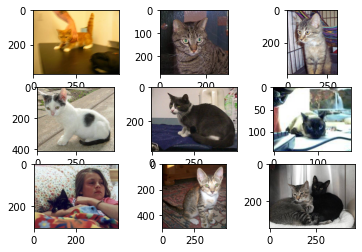

In [4]:
#looking the images
import matplotlib.pyplot as plt
from matplotlib.image import imread
folder = 'train/'
for i in range(9):
  plt.subplot(330+1+i)
  filename = folder+'cat.'+str(i)+'.jpg'
  image = imread(filename)
  plt.imshow(image)
plt.show()

#Organise Dataset Into Required Format

In [5]:
# organize dataset into a useful structure
from os import makedirs
from os import listdir
from shutil import copyfile
from random import seed
from random import random
import os

os.makedirs('test')

src_directory_files = os.listdir('train')

subdirs = ['train/', 'test/']
for subdir in subdirs:

	labeldirs = ['dogs/','cats/']
	for labldir in labeldirs:
		newdir = subdir + labldir
		makedirs(newdir)
	
seed(1)
val_ratio = 0.25
src_directory = 'train/'
for file in src_directory_files:
	src = src_directory + file
	dst_dir = 'train/'
	if random() < val_ratio:
		dst_dir = 'test/'
	if file.startswith('cat'):
		dst = dst_dir + 'cats/'  + file
		copyfile(src, dst)
	elif file.startswith('dog'):
		dst = dst_dir + 'dogs/'  + file
		copyfile(src, dst)
print('Number of Training Dogs images : {}'.format(len(os.listdir('train/dogs'))))
print('Number of Training Cats images : {}'.format(len(os.listdir('train/cats'))))
print('Number of Testing Dogs images : {}'.format(len(os.listdir('test/dogs'))))
print('Number of Testing Cats images : {}'.format(len(os.listdir('test/cats'))))

Number of Training Dogs images : 9341
Number of Training Cats images : 9356
Number of Testing Dogs images : 3159
Number of Testing Cats images : 3144


#Utility Functions

##Plotting Summary

In [0]:
def summarize_diagnostics(history,plotname):
  import matplotlib.pyplot as plt
  print('\nPlots\n')

  plt.subplot(211)
  plt.title('CrossEntropy Loss')
  plt.plot(history.history['loss'],color= 'blue', label= 'train')
  plt.plot(history.history['val_loss'], color= 'orange', label= 'test')
  plt.legend()

  plt.subplot(212)
  plt.title('Classification Accuracy')
  plt.plot(history.history['accuracy'], color= 'blue', label= 'train')
  plt.plot(history.history['val_accuracy'], color= 'orange', label= 'test')
  plt.legend()

  plt.tight_layout()
  plt.savefig(plotname+'_plot.png')
  plt.show()
  plt.close()

##Final Function to fit the model

In [0]:
def run_test_harness(model):
  datagen = ImageDataGenerator(rescale= 1./255)

  print('\nInitializing Training Data Generator\n')
  train_data_gen = datagen.flow_from_directory('train',
                                               class_mode= 'binary',
                                               batch_size= 64,
                                               target_size= (200,200))
  
  print('\nInitializing Testing Data Generator\n')
  test_data_gen = datagen.flow_from_directory('test',
                                              class_mode= 'binary',
                                              batch_size= 64,
                                              target_size= (200,200))
  
  print('\nModel Fitting\n')
  history = model.fit_generator(train_data_gen,
                                steps_per_epoch= len(train_data_gen),
                                validation_data = test_data_gen,
                                validation_steps= len(test_data_gen),
                                epochs= 20
                                )
  
  print('\nEvaluating Model\n')
  _, acc = model.evaluate_generator(test_data_gen,
                                    steps= len(test_data_gen)
                                    )
  
  print('>%.3f'%(acc*100))

  return history

#One Block of VGG Architecture

In [8]:
#Function to define model
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Conv2D, MaxPool2D, Dense, Flatten
from keras.optimizers import SGD
from keras.preprocessing.image import ImageDataGenerator

def define_model_1():
  print('\nModel Initialization\n')
  model = Sequential([
                      Conv2D(32,(3,3),activation= 'relu', kernel_initializer= 'he_uniform', padding= 'same', input_shape=(200,200,3)),
                      MaxPool2D((2,2)),
                      Flatten(),
                      Dense(128, activation= 'relu', kernel_initializer= 'he_uniform'),
                      Dense(1, activation= 'sigmoid')
  ])
  print('\nModel Compilation\n')
  model.compile(optimizer= SGD(lr = 0.001, momentum= 0.9), loss = 'binary_crossentropy', metrics= ['accuracy'])
  return model

Using TensorFlow backend.


#Two Blocks of VGG architecture

In [0]:
#Function to define model
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Conv2D, MaxPool2D, Dense, Flatten
from keras.optimizers import SGD
from keras.preprocessing.image import ImageDataGenerator

def define_model_2():
  print('\nModel Initialization\n')
  model = Sequential([
                      Conv2D(32,(3,3),activation= 'relu', kernel_initializer= 'he_uniform', padding= 'same', input_shape=(200,200,3)),
                      MaxPool2D((2,2)),
                      Conv2D(64,(3,3),activation= 'relu', kernel_initializer= 'he_uniform', padding= 'same'),
                      MaxPool2D((2,2)),
                      Flatten(),
                      Dense(128, activation= 'relu', kernel_initializer= 'he_uniform'),
                      Dense(1, activation= 'sigmoid')
  ])
  print('\nModel Compilation\n')
  model.compile(optimizer= SGD(lr = 0.001, momentum= 0.9), loss = 'binary_crossentropy', metrics= ['accuracy'])

  return model

#Three blocks of vgg architecture

In [0]:
#Function to define model
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Conv2D, MaxPool2D, Dense, Flatten
from keras.optimizers import SGD
from keras.preprocessing.image import ImageDataGenerator

def define_model_3():
  print('\nModel Initialization\n')
  model = Sequential([
                      Conv2D(32,(3,3),activation= 'relu', kernel_initializer= 'he_uniform', padding= 'same', input_shape=(200,200,3)),
                      MaxPool2D((2,2)),
                      Conv2D(64,(3,3),activation= 'relu', kernel_initializer= 'he_uniform', padding= 'same'),
                      MaxPool2D((2,2)),
                      Conv2D(128,(3,3),activation= 'relu', kernel_initializer= 'he_uniform', padding= 'same'),
                      MaxPool2D((2,2)),
                      Flatten(),
                      Dense(128, activation= 'relu', kernel_initializer= 'he_uniform'),
                      Dense(1, activation= 'sigmoid')
  ])
  print('\nModel Compilation\n')
  model.compile(optimizer= SGD(lr = 0.001, momentum= 0.9), loss = 'binary_crossentropy', metrics= ['accuracy'])

  return model

#Evaluating all the models

##Model with one block vgg architecture


Model Initialization


Model Compilation

Model Summary

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 200, 200, 32)      896       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 100, 100, 32)      0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 320000)            0         
_________________________________________________________________
dense_3 (Dense)              (None, 128)               40960128  
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 129       
Total params: 40,961,153
Trainable params: 40,961,153
Non-trainable params: 0
_________________________________________________________________
None

Initializing Training Data Generator

Found 

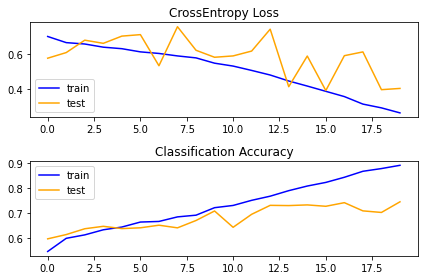

In [0]:
model_1 = define_model_1()
print('Model Summary\n')
print(model_1.summary())
history_1 = run_test_harness(model_1)
summarize_diagnostics(history_1,'one_block_vgg_architecture')
model_1.save('one_block_vgg_architecture')

##Model with two blocks vgg architecture


Model Initialization


Model Compilation

Model Summary

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 200, 200, 32)      896       
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 100, 100, 32)      0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 100, 100, 64)      18496     
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 50, 50, 64)        0         
_________________________________________________________________
flatten_5 (Flatten)          (None, 160000)            0         
_________________________________________________________________
dense_9 (Dense)              (None, 128)               20480128  
______________________________________________________________

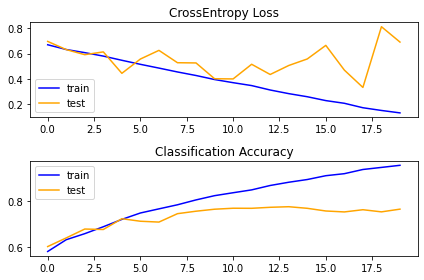

In [0]:
model_2 = define_model_2()
print('Model Summary\n')
print(model_2.summary())
history_2 = run_test_harness(model_2)
summarize_diagnostics(history_2,'two_blocks_vgg_architecture')
model_2.save('two_blocks_vgg_architecture')

##Model with three blocks vgg architecture


Model Initialization


Model Compilation

Model Summary

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_9 (Conv2D)            (None, 200, 200, 32)      896       
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 100, 100, 32)      0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 100, 100, 64)      18496     
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 50, 50, 64)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 50, 50, 128)       73856     
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 25, 25, 128)       0         
______________________________________________________________

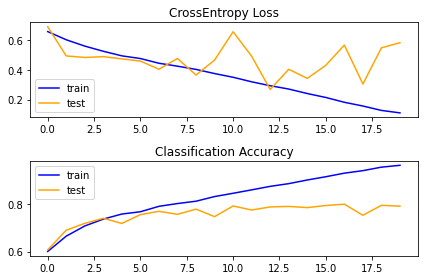

In [0]:
model_3 = define_model_3()
print('Model Summary\n')
print(model_3.summary())
history_3 = run_test_harness(model_3)
summarize_diagnostics(history_3,'three_blocks_vgg_architecture')
model_3.save('three_blocks_vgg_architecture')

#Summary
We have 3 different architectures:
1. One block VGG Architecture - 74.504% Accuracy
2. Two blocks VGG Architecture - 76.598 Accuracy
3. Three blocks VGG Architecture - 79.280 Accuracy

It seems that all of the above three architectures start to overfit the training data at some point of training. To solve this problem, we can use regularization technique such as **Image Augmentation**. This will help the network to identify extra features from the image.

#Three block vgg architecture with Image Augmentation

In [0]:
def run_test_harness_regularized(model):
  train_datagen = ImageDataGenerator(rescale= 1./255,
                               rotation_range= 45,
                               width_shift_range= 0.1,
                               height_shift_range= 0.1,
                               horizontal_flip= True
                               )
  test_datagen = ImageDataGenerator(rescale= 1./255)

  print('\nInitializing Training Data Generator\n')
  train_data_gen = train_datagen.flow_from_directory('train',
                                               class_mode= 'binary',
                                               batch_size= 64,
                                               target_size= (200,200))
  
  print('\nInitializing Testing Data Generator\n')
  test_data_gen = test_datagen.flow_from_directory('test',
                                              class_mode= 'binary',
                                              batch_size= 64,
                                              target_size= (200,200))
  
  print('\nModel Fitting\n')
  history = model.fit_generator(train_data_gen,
                                steps_per_epoch= len(train_data_gen),
                                validation_data = test_data_gen,
                                validation_steps= len(test_data_gen),
                                epochs= 50,
                                verbose= 1
                                )
  
  print('\nEvaluating Model\n')
  _, acc = model.evaluate_generator(test_data_gen,
                                    steps= len(test_data_gen)
                                    )
  
  print('>%.3f'%(acc*100))

  return history


Model Initialization

Executing op RandomUniform in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op RandomUniform in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op RandomUniform in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op RandomUniform in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op RandomUniform in device /job:localhost/replica:0/task:0/device:GPU:0

Model Compilation

Model Summary

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_13 (Conv2D)           (None, 200, 200, 32)      896       
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 100, 100, 32)      0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 100, 100, 64)      18496     
________________________________________________

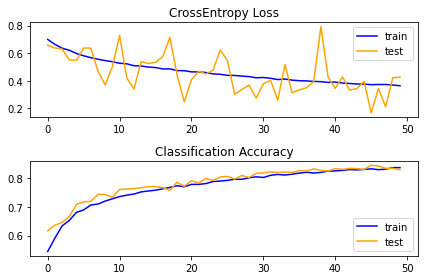

In [23]:
model_3_regularized = define_model_3()
print('Model Summary\n')
print(model_3_regularized.summary())
history_regularized_3 = run_test_harness_regularized(model_3_regularized)
summarize_diagnostics(history_regularized_3,'three_block_regularized_vgg')
model_3_regularized.save('three_block_regularized_vgg')

#Transfer Learning using VGG-16 Pretrained Model

In [0]:
from keras.utils import to_categorical
from keras.applications.vgg16 import VGG16
from keras.models import Model
from keras.layers import Dense
from keras.layers import Flatten
from keras.optimizers import SGD
from keras.preprocessing.image import ImageDataGenerator

def define_vgg16_model():
  model = VGG16(include_top= False, input_shape= (224,224,3))
  for layer in model.layers:
    layer.trainable= False
  flat1 = Flatten()(model.layers[-1].output)
  class1 = Dense(128, activation= 'relu', kernel_initializer= 'he_uniform')(flat1)
  output = Dense(1,activation= 'sigmoid')(class1)

  model = Model(inputs= model.inputs, outputs= output)
  opt = SGD(lr= 0.001, momentum= 0.9)

  model.compile(optimizer= opt, loss= 'binary_crossentropy',metrics=['accuracy'])
  return model

In [0]:
def run_test_harness_vgg16(model):
  datagen = ImageDataGenerator(featurewise_center= True)
  datagen.mean = [123.68, 116.779, 103.939]

  print('\nInitializing Training Data Generator\n')
  train_data_gen = datagen.flow_from_directory('train',
                                               class_mode= 'binary',
                                               batch_size= 64,
                                               target_size= (224,224))
  
  print('\nInitializing Testing Data Generator\n')
  test_data_gen = datagen.flow_from_directory('test',
                                              class_mode= 'binary',
                                              batch_size= 64,
                                              target_size= (224,224))
  
  print('\nModel Fitting\n')
  history = model.fit_generator(train_data_gen,
                                steps_per_epoch= len(train_data_gen),
                                validation_data = test_data_gen,
                                validation_steps= len(test_data_gen),
                                epochs= 10
                                )
  
  print('\nEvaluating Model\n')
  _, acc = model.evaluate_generator(test_data_gen,
                                    steps= len(test_data_gen)
                                    )
  
  print('>%.3f'%(acc*100))

  return history

Executing op RandomUniform in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op RandomUniform in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op RandomUniform in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op RandomUniform in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op RandomUniform in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op RandomUniform in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op RandomUniform in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op RandomUniform in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op RandomUniform in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op RandomUniform in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op RandomUniform in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op RandomUniform in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Ran

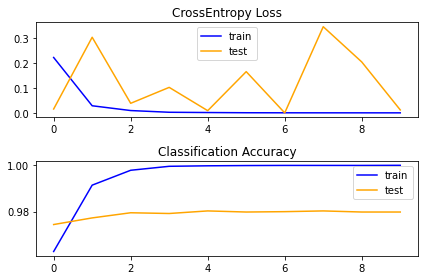

In [22]:
model_vgg16 = define_vgg16_model()
print('Model Summary\n')
print(model_vgg16.summary())
history_vgg16 = run_test_harness_vgg16(model_vgg16)
summarize_diagnostics(history_vgg16,'VGG16')

#Summary
Three block vgg architecture with Image Augmentation - 82.929% Accuracy<br>
VGG16 Pretrained Model - 97.985% Accuracy